In [2]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score

In [3]:
birds_df = pd.read_csv('birds.csv')
birds_df.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


In [4]:
unique_species_count = birds_df['labels'].nunique()
samples_per_species = birds_df['labels'].value_counts()
images_per_dataset = birds_df['data set'].value_counts()
scientific_name_consistency = birds_df.groupby('labels')['scientific name'].nunique()


summary_report = {
    "Unique Species Count": unique_species_count,
    "Samples Per Species": samples_per_species.describe(), # Statistical summary
    "Images Per Dataset": images_per_dataset,
    "Label-Scientific Name Consistency": scientific_name_consistency[scientific_name_consistency > 1] # Inconsistencies
}

summary_report


{'Unique Species Count': 525,
 'Samples Per Species': count    525.000000
 mean     171.209524
 std       20.621588
 min      140.000000
 25%      160.000000
 50%      168.000000
 75%      180.000000
 max      273.000000
 Name: labels, dtype: float64,
 'Images Per Dataset': train    84635
 test      2625
 valid     2625
 Name: data set, dtype: int64,
 'Label-Scientific Name Consistency': Series([], Name: scientific name, dtype: int64)}

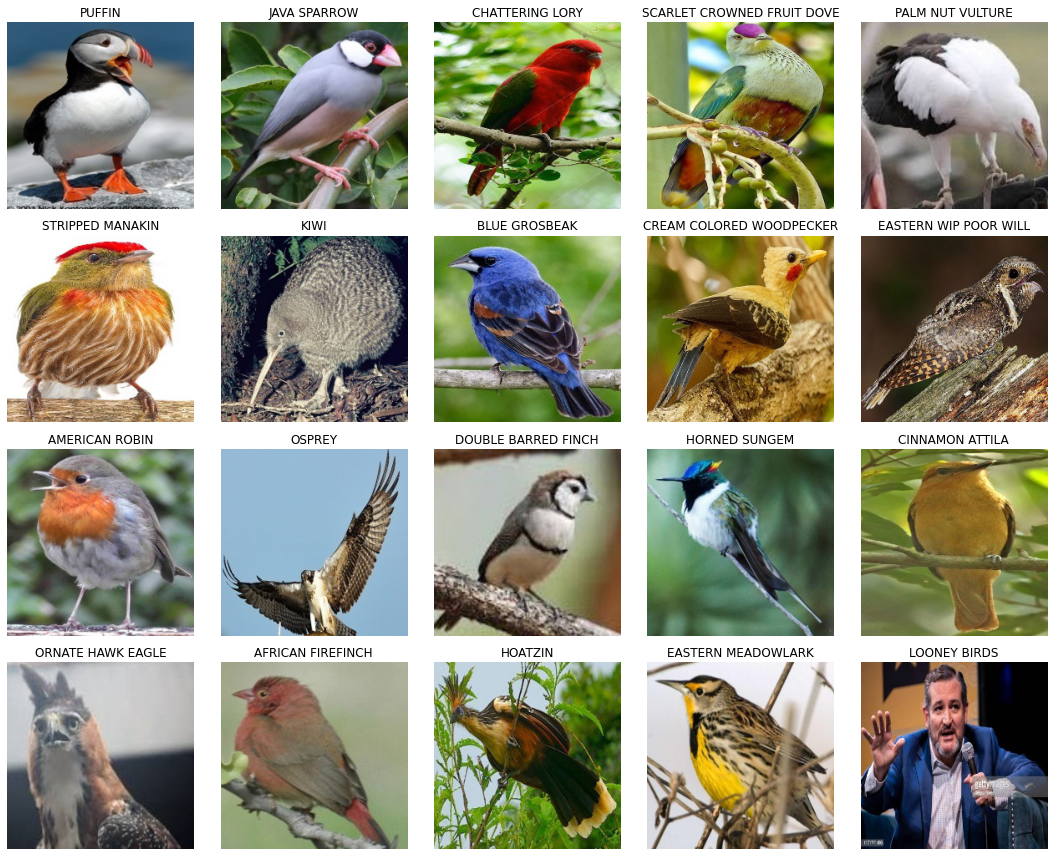

In [5]:
base_dir = 'train'

species_train_dirs = os.listdir(base_dir)


selected_species = random.sample(species_train_dirs, 20)


selected_images = []
for species in selected_species:
    species_dir = os.path.join(base_dir, species)
    chosen_image = random.choice(os.listdir(species_dir))
    selected_images.append((chosen_image, species))


def load_and_display_images(image_info_list, images_per_row=5):
    num_images = len(image_info_list)
    num_rows = num_images // images_per_row + (num_images % images_per_row > 0)
    
    plt.figure(figsize=(images_per_row * 3, num_rows * 3))
    for i, (image_name, species) in enumerate(image_info_list, 1):
        img_path = os.path.join(base_dir, species, image_name)
        img = image.load_img(img_path, target_size=(224, 224))
        plt.subplot(num_rows, images_per_row, i)
        plt.imshow(img)
        plt.title(species)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


load_and_display_images(selected_images)



In [6]:
image_dir = Path(base_dir)
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


image_df = pd.concat([filepaths, labels], axis=1)

image_dir = Path('test')
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


test_df = pd.concat([filepaths, labels], axis=1)

image_dir = Path('valid')
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


valid_df = pd.concat([filepaths, labels], axis=1)

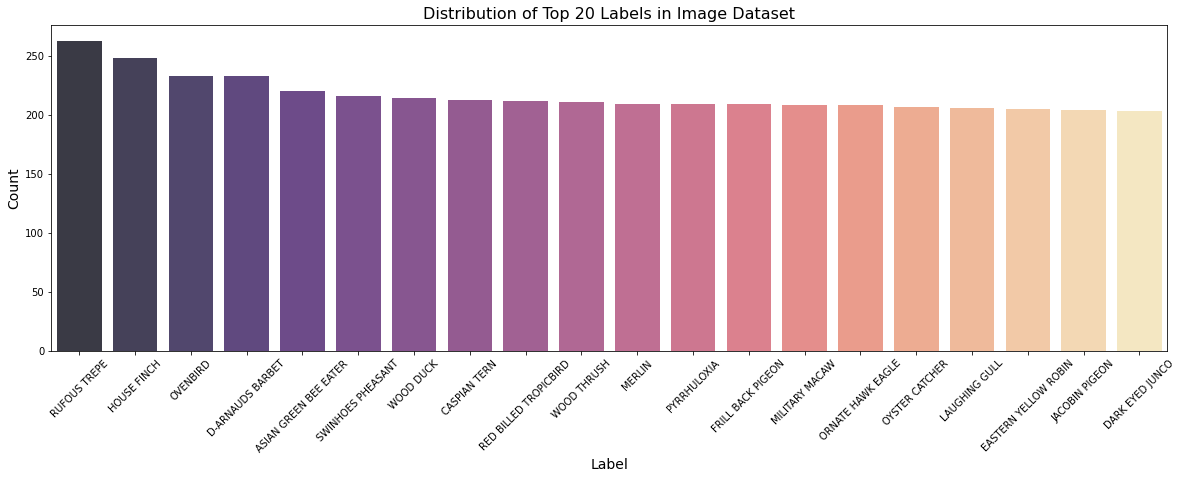

In [7]:
import seaborn as sns


top_20_label_counts =  image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))


sns.barplot(x=top_20_label_counts.index, y=top_20_label_counts.values, alpha=0.8, palette='magma')


plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)


plt.xticks(rotation=45)


plt.show()

In [27]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [28]:
batchsize = 32
targetsize = (224, 224)

train_images = train_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=targetsize,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batchsize,
    shuffle=True,
    seed=42
    
)

val_images = train_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepath',
    y_col='Label',
    target_size=targetsize,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batchsize,
    shuffle=True,
    seed=42
    
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=targetsize,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batchsize,
    shuffle=False
)


Found 84635 validated image filenames belonging to 525 classes.
Found 2625 validated image filenames belonging to 525 classes.
Found 2625 validated image filenames belonging to 525 classes.


In [22]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*TARGET_SIZE, 3)), # Input layer with shape (224, 224, 3)
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5), 
    Dense(525, activation='softmax') 
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    epochs=10, 
    validation_data=val_images,
    validation_steps=len(val_images)
)


eval_result = model.evaluate(test_images)
print(f'Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}')


model.save('bird_species_cnn_model.h5')

Epoch 1/10
2645/2645 [==============================] - 229s 86ms/step - loss: 6.3920 - accuracy: 0.0030 - val_loss: 6.2660 - val_accuracy: 0.0019
Epoch 2/10
2645/2645 [==============================] - 179s 68ms/step - loss: 6.0904 - accuracy: 0.0086 - val_loss: 5.6915 - val_accuracy: 0.0282
Epoch 3/10
2645/2645 [==============================] - 169s 64ms/step - loss: 5.4458 - accuracy: 0.0458 - val_loss: 4.7072 - val_accuracy: 0.1269
Epoch 4/10
2645/2645 [==============================] - 166s 63ms/step - loss: 4.7273 - accuracy: 0.1187 - val_loss: 3.9516 - val_accuracy: 0.2278
Epoch 5/10
2645/2645 [==============================] - 165s 62ms/step - loss: 4.1307 - accuracy: 0.1985 - val_loss: 3.4687 - val_accuracy: 0.3025
Epoch 6/10
2645/2645 [==============================] - 168s 63ms/step - loss: 3.6251 - accuracy: 0.2690 - val_loss: 3.1949 - val_accuracy: 0.3562
Epoch 7/10
2645/2645 [==============================] - 173s 65ms/step - loss: 3.2059 - accuracy: 0.3338 - val_loss: 3

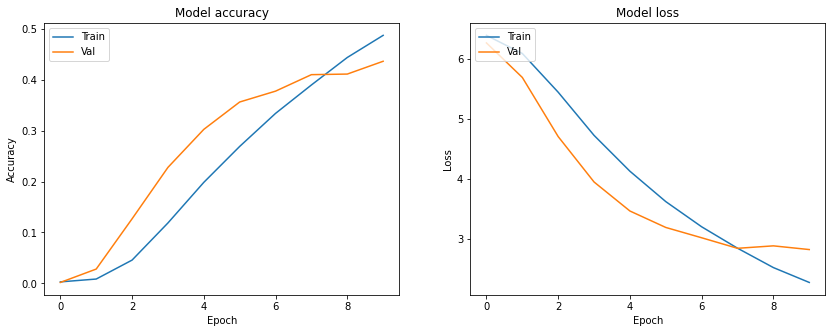

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()


In [24]:


predictions_proba = model.predict(test_images)
predictions = predictions_proba.argmax(axis=1)  
true_classes = test_images.classes 

In [25]:



f1_macro = f1_score(true_classes, predictions, average='macro')
print(f'F1 Score (Macro): {f1_macro}')


F1 Score (Macro): 0.4309498917961122


In [26]:

n_classes = len(test_images.class_indices)
true_classes_binarized = label_binarize(true_classes, classes=[i for i in range(n_classes)])


roc_auc = roc_auc_score(true_classes_binarized, predictions_proba, multi_class='ovr')  # 'ovr' means One-vs-Rest
print(f'ROC AUC: {roc_auc}')


ROC AUC: 0.9712892766266812


Transfer Learning

In [29]:



base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*TARGET_SIZE, 3))


base_model.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(525, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_bird_species_cnn_model.h5', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001, verbose=1)


history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    epochs=10, 
    validation_data=val_images,
    validation_steps=len(val_images),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)




16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/10
2645/2645 [==============================] - ETA: 0s - loss: 1.2952 - accuracy: 0.6912
Epoch 00001: val_loss improved from inf to 0.30234, saving model to best_bird_species_cnn_model.h5


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2645/2645 [==============================] - 211s 78ms/step - loss: 1.2952 - accuracy: 0.6912 - val_loss: 0.3023 - val_accuracy: 0.9173 - lr: 0.0010
Epoch 2/10
2645/2645 [==============================] - ETA: 0s - loss: 0.6340 - accuracy: 0.8306
Epoch 00002: val_loss improved from 0.30234 to 0.25972, saving model to best_bird_species_cnn_model.h5
2645/2645 [==============================] - 191s 72ms/step - loss: 0.6340 - accuracy: 0.8306 - val_loss: 0.2597 - val_accuracy: 0.9295 - lr: 0.0010
Epoch 3/10
2645/2645 [==============================] - ETA: 0s - loss: 0.5391 - accuracy: 0.8572
Epoch 00003: val_loss improved from 0.25972 to 0.24348, saving model to best_bird_species_cnn_model.h5
2645/2645 [==============================] - 173s 65ms/step - loss: 0.5391 - accuracy: 0.8572 - val_loss: 0.2435 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 4/10
2645/2645 [==============================] - ETA: 0s - loss: 0.4808 - accuracy: 0.8721
Epoch 00004: val_loss improved from 0.24348 to 0.2279

AttributeError: 'Sequential' object has no attribute 'load_model'

In [30]:
best_model = load_model('best_bird_species_cnn_model.h5')  
eval_result = best_model.evaluate(test_images)  
print(f'Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}')

83/83 [==============================] - 8s 86ms/step - loss: 0.5645 - accuracy: 0.8796
Test Loss: 0.564523458480835, Test Accuracy: 0.8796190619468689


In [31]:
test_predictions_proba = best_model.predict(test_images)
test_predictions = np.argmax(test_predictions_proba, axis=1)
true_classes = test_images.classes

f1_macro = f1_score(true_classes, test_predictions, average='macro')
print(f'F1 Score (Macro): {f1_macro}')

true_classes_binarized = to_categorical(true_classes, num_classes=n_classes)
roc_auc = roc_auc_score(true_classes_binarized, test_predictions_proba, multi_class='ovr')
print(f'AUROC: {roc_auc}')


NameError: name 'np' is not defined